In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("data.csv", index_col="Date")
import math
import warnings
warnings.filterwarnings("ignore")

In [55]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()[["Close"]] 
    
    # Adjust the input columns to get the current day's close as the last input feature
    for i in range(1, input_length):
        df[f'x_{i}'] = df['Close'].shift(i)

    # Get the next 14 days for response values
    for j in range(output_length):
        df[f'y_{j}'] = df['Close'].shift(-j-1)
    
    df = df.dropna(axis=0)
    return df
window = 120
window_df = window_input_output(window, 14, data) # multiple columns for response variables
full_window_df = data.merge(window_df.drop(columns=["Close"]), left_on='Date', right_on='Date', how='inner')

train/test split

In [56]:
from sklearn.model_selection import TimeSeriesSplit
df = full_window_df.copy()
train_size = int(len(df) * 0.9)
test_size = int(len(df) * 0.1)
# Split the DataFrame into df_train and df_test
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:train_size+test_size]
# Separate features and target variables
X = df_train.drop(columns=[f'y_{i}' for i in range(14)])
y = df_train[[f'y_{i}' for i in range(14)]]
tscv = TimeSeriesSplit(n_splits=5, test_size=len(df_train)//10) 
#model needs to predict up to two weeks into future
#we use expanding windows, enuring within each fold the train data isnt exposed to test data
# Separate features and target variables
X_test = df_test.drop(columns=[f'y_{i}' for i in range(14)])
y_test = df_test[[f'y_{i}' for i in range(14)]]




regression

In [57]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
lm_seq = LinearRegression()
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
dt_seq = DecisionTreeRegressor(random_state=42)
from sklearn.ensemble import RandomForestRegressor
rf_seq = RandomForestRegressor(n_estimators=300, random_state=42)
##Chained Regression
from sklearn.multioutput import RegressorChain

lm_chain = RegressorChain(LinearRegression())


for train_index, test_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    #lm_seq.fit(X_train, y_train)
    #lm_seq_pred = lm_seq.predict(X_val)
    # Create a dictionary of parameter values to search over
    param_grid = {'n_features_to_select': [5, 10, 15, 20, 25, 30, 40, 50]}

    # Create an instance of RFE
    lm_rfe = RFE(estimator=lm_seq)
    lm_grid_search = GridSearchCV(estimator=lm_rfe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
    lm_grid_search.fit(X_train, y_train)
    lm_best_n_features = lm_grid_search.best_params_['n_features_to_select']
    print("Best n_features_to_select for lm:", lm_best_n_features)

    rfe_lm_seq = RFE(estimator=lm_seq, n_features_to_select=lm_best_n_features)
    X_train_rfe_lm_seq = rfe_lm_seq.fit_transform(X_train, y_train)
    X_val_rfe_lm_seq = rfe_lm_seq.transform(X_val)  
    lm_seq.fit(X_train_rfe_lm_seq, y_train)
    lm_seq_pred = lm_seq.predict(X_val_rfe_lm_seq)

    dt_seq.fit(X_train, y_train)
    dt_seq_pred = dt_seq.predict(X_val) 
    rf_seq.fit(X_train, y_train)
    rf_seq_pred = rf_seq.predict(X_val)   
    lm_chain.fit(X_train, y_train)
    lm_chain_pred = lm_chain.predict(X_val)

Best n_features_to_select for lm: 10
Best n_features_to_select for lm: 5
Best n_features_to_select for lm: 5
Best n_features_to_select for lm: 10
Best n_features_to_select for lm: 50


Test Models

- seems that lm has the best performance in terms of next day prediction, having RMSE: 11.22. Chained regression gives the best avareaged performance over the two weeks, given it is able to take in previous days' prediction as a regressor variable, so we use this for the prupose of submitting the predictions.csv. This may not be as useful in practice, as we expect to run the model day by day.

In [58]:
lm_seq_pred = lm_seq.predict(rfe_lm_seq.transform(X_test))
dt_seq_pred = dt_seq.predict(X_test) 
rf_seq_pred = rf_seq.predict(X_test)   
lm_chain_pred = lm_chain.predict(X_test)

# Calculate MSE for each output column
rmse_rf = [math.sqrt(mean_squared_error(y_test.iloc[:, i], rf_seq_pred[:, i])) for i in range(y_test.shape[1])]
rmse_dt = [math.sqrt(mean_squared_error(y_test.iloc[:, i], dt_seq_pred[:, i])) for i in range(y_test.shape[1])]
rmse_lm = [math.sqrt(mean_squared_error(y_test.iloc[:, i], lm_seq_pred[:, i])) for i in range(y_test.shape[1])]
rmse_lm_chain = [math.sqrt(mean_squared_error(y_test.iloc[:, i], lm_chain_pred[:, i])) for i in range(y_test.shape[1])]
test_rmse_df = pd.DataFrame({
    'rf': rmse_rf,
    'dt': rmse_dt,
    'lm': rmse_lm,
    'chain_lm': rmse_lm_chain
})
print(test_rmse_df) 

            rf          dt         lm   chain_lm
0   188.325207  199.952352  11.782305  13.839416
1   191.138532  202.971280  17.125489  22.089081
2   193.335154  200.455877  20.235047  25.420710
3   195.623854  203.854954  23.705235  26.604843
4   199.110842  211.656348  25.682217  27.469575
5   202.435887  214.257650  27.964198  28.254368
6   205.566684  211.326479  29.432833  30.886333
7   208.078693  212.822052  31.683523  32.035977
8   208.366318  215.746523  33.195291  32.214682
9   209.431813  209.288559  35.199915  35.094717
10  211.510183  209.234277  37.656125  37.592066
11  213.353400  210.897234  39.665777  38.537707
12  213.827776  213.994388  41.780612  38.266236
13  213.733716  209.124271  42.765996  38.685621


visualisation

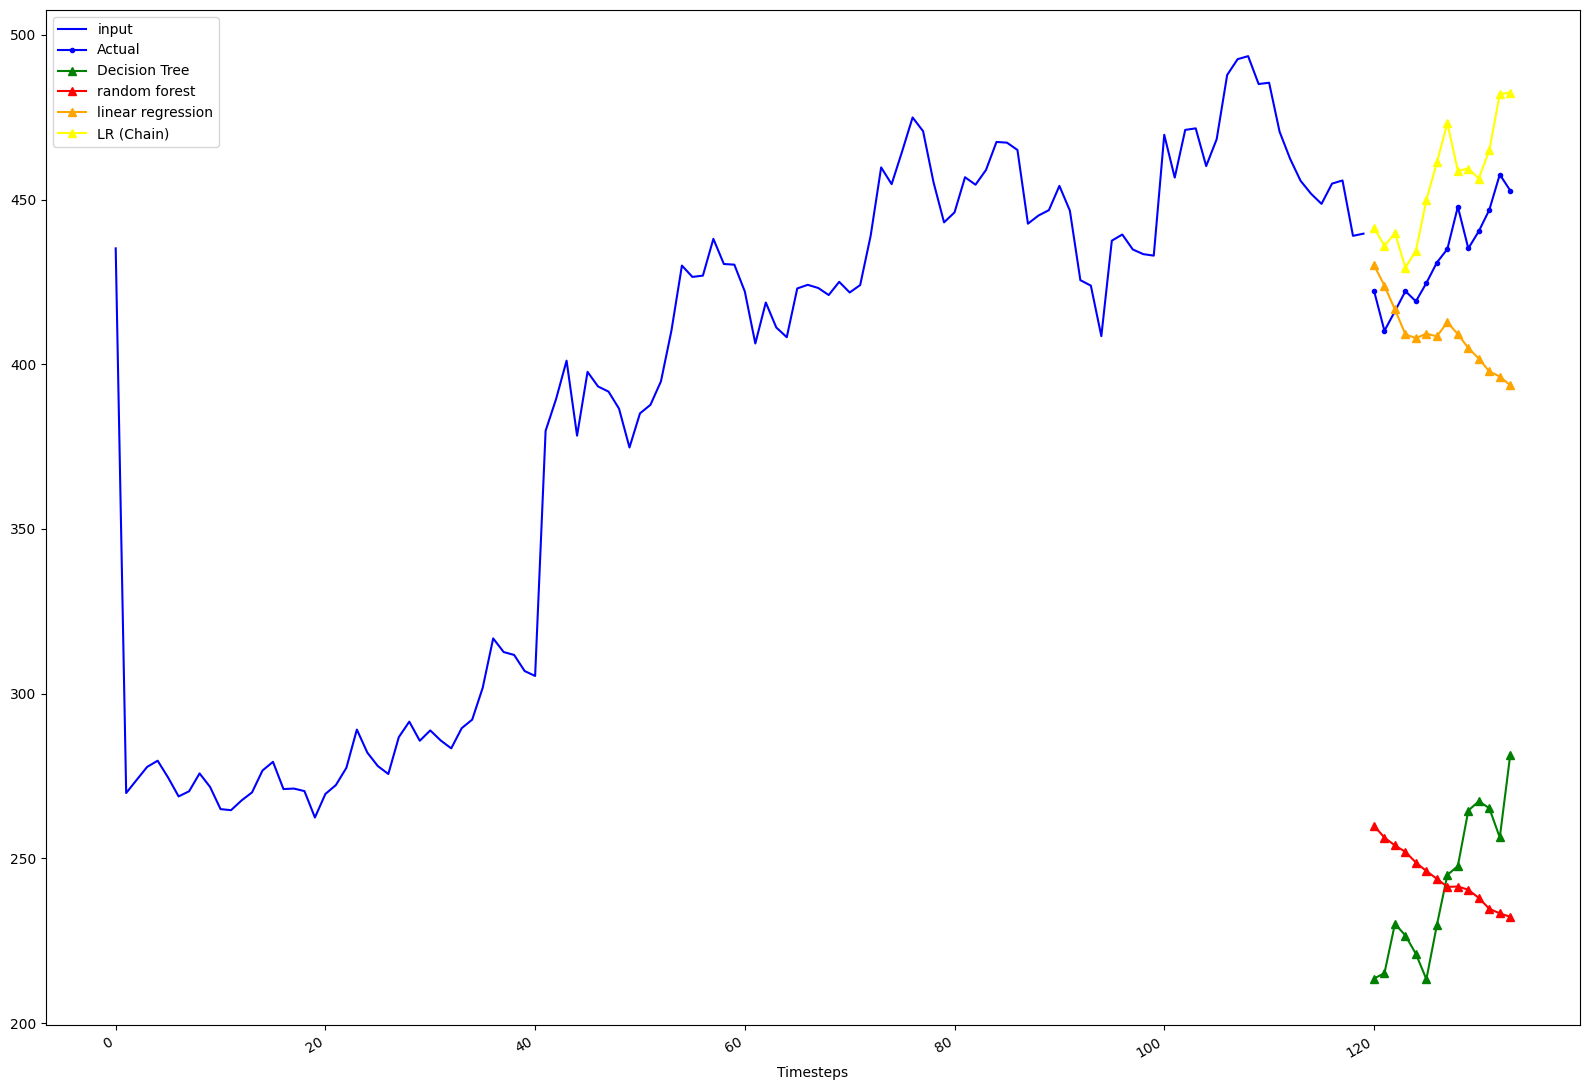

In [59]:

#visualise predictions
fig, ax = plt.subplots(figsize=(16, 11))
t= 55
columns = [f'x_{i}' for i in range(1, window)] + ["Close"]
ax.plot(np.arange(window-1, -1, -1), X_test[columns].iloc[t], 'b-', label='input')
ax.plot(np.arange(window, window+14, 1), y_test.iloc[t], marker='.', color='blue', label='Actual')
ax.plot(np.arange(window, window+14, 1), dt_seq_pred[t], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(window, window+14, 1), rf_seq_pred[t], marker='^', color='red', label='random forest')
ax.plot(np.arange(window, window+14, 1), lm_seq_pred[t], marker='^', color='orange', label='linear regression')
ax.plot(np.arange(window, window+14, 1), lm_chain_pred[t], marker='^', color='yellow', label='LR (Chain)')

ax.set_xlabel('Timesteps')
plt.legend()

fig.autofmt_xdate()
plt.tight_layout()


Submit Prediction- we use chain regression

In [60]:
df1 = data.copy()[["Close"]] 
for i in range(1, 120):
    df1[f'x_{i}'] = df1['Close'].shift(i)
df1 = df1.dropna(axis=0)

full_df1 = data.merge(df1.drop(columns=["Close"]), left_on='Date', right_on='Date', how='inner')
new_row = full_df1.iloc[-1]


# Convert the Series to DataFrame for reshaping
new_row_df = pd.DataFrame([new_row])
# Prepare this row for making predictions
X_new_last = new_row_df.values.reshape(1, -1)

# If you used RFE for feature selection for Linear Regression
X_new_last_rfe_lm_seq = rfe_lm_seq.transform(X_new_last)

lm_chain_forecast = lm_chain.predict(X_new_last)
print(lm_chain_forecast)

[[465.94763851 486.32144187 491.38443128 481.76010754 477.81033055
  464.69115033 481.05416152 484.72893078 482.60717493 478.88580795
  469.24686744 470.83410279 457.42098532 464.59600296]]
